# ETL for AI-Powered Messaging

> This repository presents a redacted, simulated version of a capstone project developed under NDA with a Canadian AI company. It illustrates generalizable techniques in ETL, information extraction, and preparation for LLM message generation workflows.



## Overview

This project focuses on building a robust and scalable data pipeline that extracts structured information from public 10-K annual reports. The extracted features are designed to support downstream AI applications, such as personalized sales message generation using LLMs. The pipeline is optimized to handle noisy, unstructured HTML documents, and scale across thousands of companies.

[View Presentation Slides](https://docs.google.com/presentation/d/1E5HGHGIrSbLAhTI5gE3Lx6DWvD-1scxTr3RYDzV9ems/edit)

[View Full Project Report](https://github.com/spencerfliao/etl-for-llm-sales-messaging/blob/1a6e655edab99ad14279b28e673204801ce67f15/report.pdf)

### Project Objectives

- Parse public 10-K filings and extract meaningful company-level attributes
- Design scalable ETL pipelines suitable for integration with a relational database
- Enhance the feature coverage and specificity of company profiles for downstream use
- Prepare data for use in RAG pipelines to power AI-generated outreach messages



### Pipeline Architecture

1. **SEC 10-K Filings (HTML)** – Raw HTML filings as input
2. **HTML Preprocessing & Parsing** – Extracts relevant sections and cleans up formatting
3. **Section Segmentation** – Breaks documents into logical units (e.g. Risk Factors, Business Overview)
4. **Information Extraction Scripts** – Pulls key terms, metrics, and attributes
5. **Feature Dictionary Construction** – Builds structured representations for each company
6. **Structured Output** – Saves as CSV or JSON
7. **(Optional) Database Upload** – Prepared for integration into PostgreSQL


**Team Members:**
- Spencer Liao  
- Haochen He
- Desmond Bai
- Daniel Jimenez

**Supervisors:**
- Miikka Silfverberg | UBC Professor
- Partner Company Team

---

Imports

In [160]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from tqdm import tqdm
from fuzzywuzzy import process

## 1. Search Functionality

Function to quickly get BeautifulSoup from requests

In [159]:
def get_soup(url):
    response = requests.get(url, headers={"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.93 Safari/537.36"})
    soup = BeautifulSoup(response.text, 'html.parser')
    return soup

Function that searches for CIK on SEC EDGAR using company name, returns either single or list of results

In [ ]:
def search_cik(company_name):
    def fetch_data(key):
        search_url = f'https://www.sec.gov/cgi-bin/browse-edgar?company={key}&match=&filenum=&State=&Country=&SIC=&owner=exclude&Find=Find+Companies&action=getcompany'
        response = requests.get(search_url, headers={"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.93 Safari/537.36"})
        if response.status_code != 200:
            return "Failed to fetch data"

        soup = BeautifulSoup(response.text, 'html.parser')

        # Check if it's a detailed single company page
        company_info = soup.find('div', class_='companyInfo')
        if company_info:
            cik = company_info.find('a').get_text(strip=True)[:10]
            company_name = company_info.find('span', class_='companyName').text.split(' CIK')[0]
            return cik, company_name

        # Check if it's a list of companies
        table = soup.find('table', class_='tableFile2')
        if table:
            companies = []
            rows = table.find_all('tr')[1:]
            for row in rows:
                cik = row.find_all('td')[0].find('a').get_text(strip=True)
                company_name = row.find_all('td')[1].get_text(strip=True)
                companies.append((cik, company_name))
            return companies

        return None
    
    key = company_name.lower()
    if len(key) > 1 and key[1] == '&':
        key = key.replace('&', '%26')

    result = fetch_data(key)

    if result is None and 'corporation' in key:
        key = key.replace('corporation', 'corp')
        result = fetch_data(key)
    if result is None and 'group' in key:
        key = key.replace('group', '')
        result = fetch_data(key)
    if result is None and ',' in key:
        key = key.replace(',', '')
        result = fetch_data(key)
    if result is None and ' and ' in key:
        key = key.replace(' and ', ' & ')
        result = fetch_data(key)
    if result is None and 'company' in key:
        key = key.replace('company', 'co')
        result = fetch_data(key)
    
    return result

search_cik('Intercom')

Fuctions that finds the best match and produces the CIK url

In [157]:
def get_cik_url(company_name):
    search_result = search_cik(company_name)
    if search_result is None:
        return None
    elif isinstance(search_result, tuple):
        cik = search_result[0]
    elif isinstance(search_result, list) and search_result:
        # Use fuzzy matching to find the closest result
        company_names = [result[1] for result in search_result]
        
        # Perform fuzzy matching
        closest_matches = process.extract(company_name, company_names, limit=5)
        
        # Filter and prioritize exact matches or highly similar ones
        best_match = None
        highest_score = 0
        for match in closest_matches:
            name, score = match
            if score > highest_score and ('inc' in name.lower() or 'corp' in name.lower()):
                highest_score = score
                best_match = name
        
        # Initialize cik with a default value
        cik = None
        
        # Find the CIK for the best match
        if best_match:
            for result in search_result:
                if result[1] == best_match:
                    cik = result[0]
                    break

        # If no suitable match is found, fallback to the closest match
        if cik is None:
            closest_match = process.extractOne(company_name, company_names)
            for result in search_result:
                if result[1] == closest_match[0]:
                    cik = result[0]
                    break
    else:
        return None
    
    if cik is None:
        return None
    
    cik_url = f'https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK={cik}&type=10-K&dateb=&owner=exclude&count=40'
    return cik_url

cik_url = get_cik_url('Blue Buffalo')
cik_url

Function to get the url to 10-K filing document in HTML format, with CIK url as key

In [13]:
def get_10k_url(cik_url):
    soup1 = get_soup(cik_url)

    filing_detail_url = None
    html_url = None
    link1 = None
    link2 = None

    # finding the first 10-K link on the CIK page -> filing detail
    table_rows_1 = soup1.find_all('tr')
    for row in table_rows_1:
        if '10-K' in row.text and '10-K/A' not in row.text:
            link1 = row.find('a')['href']
            break
    if link1:
        filing_detail_url = 'https://www.sec.gov' + link1

        soup2 = get_soup(filing_detail_url)
        table_rows_2 = soup2.find_all('tr')

        # finding 10-k doc from filing detail page
        for row in table_rows_2:
            if '10-K' in row.text:
                link2 = row.find('a')['href']
                break
        if link2:
            xbrl_url = 'https://www.sec.gov' + link2
            html_url = xbrl_url.replace('ix?doc=/', '')

    return html_url

html_url = get_10k_url(cik_url)
html_url

'https://www.sec.gov/Archives/edgar/data/1609989/000160998918000019/bluebuffalo12311710-k.htm'

In [14]:
def get_10k_file(html_url):
    
    if html_url is not None:
        response = requests.get(html_url, headers={"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.93 Safari/537.36"})
        return response.text
    else:
        return None

## 2. Parse Functionality

In [15]:
html_url = get_10k_url(cik_url)
doc_10k = get_10k_file(html_url)

Function to find all section title names

In [16]:
from bs4 import BeautifulSoup, Tag

def extract_sections_titles(html_content):
    soup = BeautifulSoup(html_content, 'html.parser')
    sections = []
    
    # Find all 'table tr' elements
    table_rows = soup.find_all('tr')
    for row in table_rows:
        if 'Business' in row.text:
            parent_node = row.parent
            for sibling in parent_node.children:
                if isinstance(sibling, Tag):  # Check if the sibling is a Tag object
                    a_tags = sibling.find_all('a')
                    combined_text = ""
                    for a_tag in a_tags:
                        text = a_tag.get_text().strip()
                        # Skip page numbers, signatures, and ensure href is assigned only once
                        if text and not text.isdigit() and 'signature' not in text.lower() and 'item' not in text.lower() and 'part' not in text.lower():
                            combined_text += text
                    if combined_text and combined_text not in sections:
                        sections.append(combined_text)
                        
    return sections

Function to find all section title names and href links

In [17]:
def extract_section_and_links(html_content):
    soup = BeautifulSoup(html_content, 'html.parser')
    sections = {}
    
    # Find all 'table tr' elements
    table_rows = soup.find_all('tr')
    for row in table_rows:
        if 'Business' in row.text:
            parent_node = row.parent
            for sibling in parent_node.children:
                a_tags = sibling.find_all('a')
                combined_text = ""
                href = ""
                for a_tag in a_tags:
                    text = a_tag.get_text().strip()
                    # Skip page numbers, signatures, and ensure href is assigned only once
                    if text and not text.isdigit() and 'signature' not in text.lower() and 'item' not in text.lower() and 'part' not in text.lower():
                        combined_text += text
                        if not href:
                            href = a_tag['href'].strip('#')
                if combined_text:
                    sections[combined_text] = href
                        
    return sections

In [18]:
section_links = extract_section_and_links(doc_10k)
sections_df = pd.DataFrame(list(section_links.items()), columns=['Section Title', 'Link'])
sections_df

,Section Title,Link
0,Business,sCFD89D1EFF2E5293B86B54AFC1B3E429
1,Risk Factors,sE0B3F0F9C141501D99BC795B94F63D64
2,Unresolved Staff Comments,s9302553BB168589C93C7FC833AF6EA4F
3,Properties,sECEB3774BEDD5B739B854E5E8489C0D4
4,Legal Proceedings,sA147E4A7EE1C5F59A27CF898FA0C3F54
5,Mine Safety Disclosures,s4D666224DFE7509C91EDA75AC0A2B315
6,"Market for the Registrant’s Common Equity, Rel...",s810C1C726DBF523C81382B1D16F1148D
7,Selected Financial Data,sE916212FBD485BA9857CCDA87D452815
8,Management’s Discussion and Analysis of Financ...,sDD8D7E29282A5C5B828C887406C7ED20
9,Quantitative and Qualitative Disclosures about...,s1A0401606D2857BFACCDB8FDD3658E17


In [20]:
def extract_sections(html_content):
    soup = BeautifulSoup(html_content, 'html.parser')
    sections = {}

    table_rows = soup.find_all('tr')
    links_to_process = []

    for row in table_rows:
        if 'Business' in row.text or 'Risk Factors' in row.text:  # Example section titles
            parent_node = row.parent
            for sibling in parent_node.children:
                if isinstance(sibling, Tag):
                    a_tags = sibling.find_all('a')
                    combined_text = ""
                    href = ""
                    for a_tag in a_tags:
                        text = a_tag.get_text().strip()
                        if text and not text.isdigit() and 'signature' not in text.lower() and 'item' not in text.lower() and 'part' not in text.lower():
                            combined_text += text
                            if not href:
                                href = a_tag['href'].strip('#')

                    if combined_text and href:
                        links_to_process.append((combined_text, href))

    for i, (combined_text, href) in enumerate(links_to_process):
        section_div = soup.find('div', id=href)
        if not section_div:
            section_div = soup.find('div', attrs={'name': href})
        if not section_div:
            section_div = soup.find('a', attrs={'name': href})
            if section_div:
                section_div = section_div.parent

        section_content = ""
        if section_div:
            next_node = section_div.find_next_sibling()
            next_href = links_to_process[i + 1][1] if i + 1 < len(links_to_process) else None
            while next_node and ('id' not in next_node.attrs or ('id' in next_node.attrs and next_node['id'] != next_href)):
                if next_node.name and next_node.name != 'hr':
                    section_content += next_node.get_text(separator=' ', strip=True) + "\n"
                next_node = next_node.find_next_sibling()
        
        sections[combined_text] = section_content.strip()

    return sections

In [21]:
section_dict = extract_sections(doc_10k)
sections_df = pd.DataFrame(list(section_dict.items()), columns=['Section Title', 'Content'])
sections_df

,Section Title,Content
0,Business,ITEM 1. BUSINESS\nProposed Merger with General...
1,Risk Factors,ITEM 1A. RISK FACTORS\nYou should carefully co...
2,Unresolved Staff Comments,ITEM 1B. UNRESOLVED STAFF COMMENTS\nNone.\n\nI...
3,Properties,ITEM 2. PROPERTIES\nThe following table sets f...
4,Legal Proceedings,ITEM 3. LEGAL PROCEEDINGS\nWe are a party to a...
5,Mine Safety Disclosures,ITEM 4. MINE SAFETY DISCLOSURES\nNot applicabl...
6,"Market for the Registrant’s Common Equity, Rel...",ITEM 5. MARKET FOR THE REGISTRANT'S COMMON EQU...
7,Selected Financial Data,ITEM 6. SELECTED FINANCIAL DATA\n\nThe followi...
8,Management’s Discussion and Analysis of Financ...,"ITEM 7. BLUE BUFFALO PET PRODUCTS, INC. MANAGE..."
9,Quantitative and Qualitative Disclosures about...,ITEM 7A. QUANTITATIVE AND QUALITATIVE DISCLOSU...


Example of output

In [ ]:
print(sections_df['Content'][0])

## 3. Evaluation

Importing company names from database

In [23]:
import json
import urllib.parse
import pandas as pd
from ast import literal_eval
from sqlalchemy import create_engine

with open('/Users/SFL/Documents/1 Learn/UBC/Capstone/credentials.json') as f:
    login = json.load(f)
    
username = login['user']
password = urllib.parse.quote(login['password'])
host = login['host']
port = login['port']

conn = create_engine(f'postgresql://{username}:{password}@{host}:{port}/postgres')

orgs = pd.read_sql_query(
    """
    SELECT DISTINCT organization
    FROM rocketbrew_0424.address_book_supplement
    WHERE organization_name <> 'NONE'
    """,
    conn
    )["organization"]

orgs = [literal_eval(org) for org in orgs]

company_urls = [(org["name"],org["website_url"]) for org in orgs]

data = pd.DataFrame(company_urls,columns=["names","urls"])

In [24]:
data

,names,urls
0,"Radius Health, Inc.",http://www.radiuspharm.com
1,GSK,http://www.gskbio.com
2,Echoworx,http://www.echoworx.com
3,Boyd Gaming,http://www.boydgaming.com
4,Blue Sky Network,http://www.blueskynetwork.com
...,...,...
14323,Optum,http://www.optum.com
14324,Integrity Marketing Group LLC,None
14325,Lecsor Inc,None
14326,Maple City Country Club,http://www.maplecitycc.com


In [25]:
url_df = pd.read_csv('/Users/SFL/Documents/1 Learn/UBC/Capstone/data/training_urls.csv')
url_df.columns = ['urls']
merged_df = pd.merge(url_df, data, left_on='urls', right_on='urls', how='left')
train_names = merged_df['names'].tolist()
train_names = list(set(train_names))

In [26]:
all_cik_results = []
for item in tqdm(train_names):
    result = get_cik_url(item)
    all_cik_results.append(result)

100%|██████████| 3294/3294 [12:52<00:00,  4.27it/s]  


In [27]:
valid_cik_results = [result for result in all_cik_results if result is not None]

In [28]:
all_10k_results = []
for item in tqdm(valid_cik_results):
    result = get_10k_url(item)
    all_10k_results.append(result)

100%|██████████| 956/956 [02:53<00:00,  5.51it/s]


In [29]:
valid_10k_results = [result for result in all_10k_results if result is not None]

Evaluating 10-K parsing algorithm

In [31]:
parsed_10k = []
for item in tqdm(valid_10k_results):
    html_content = get_10k_file(item)
    result = extract_sections(html_content)
    parsed_10k.append(result)

100%|██████████| 187/187 [14:25<00:00,  4.63s/it]


Visualizing Section Title Stats

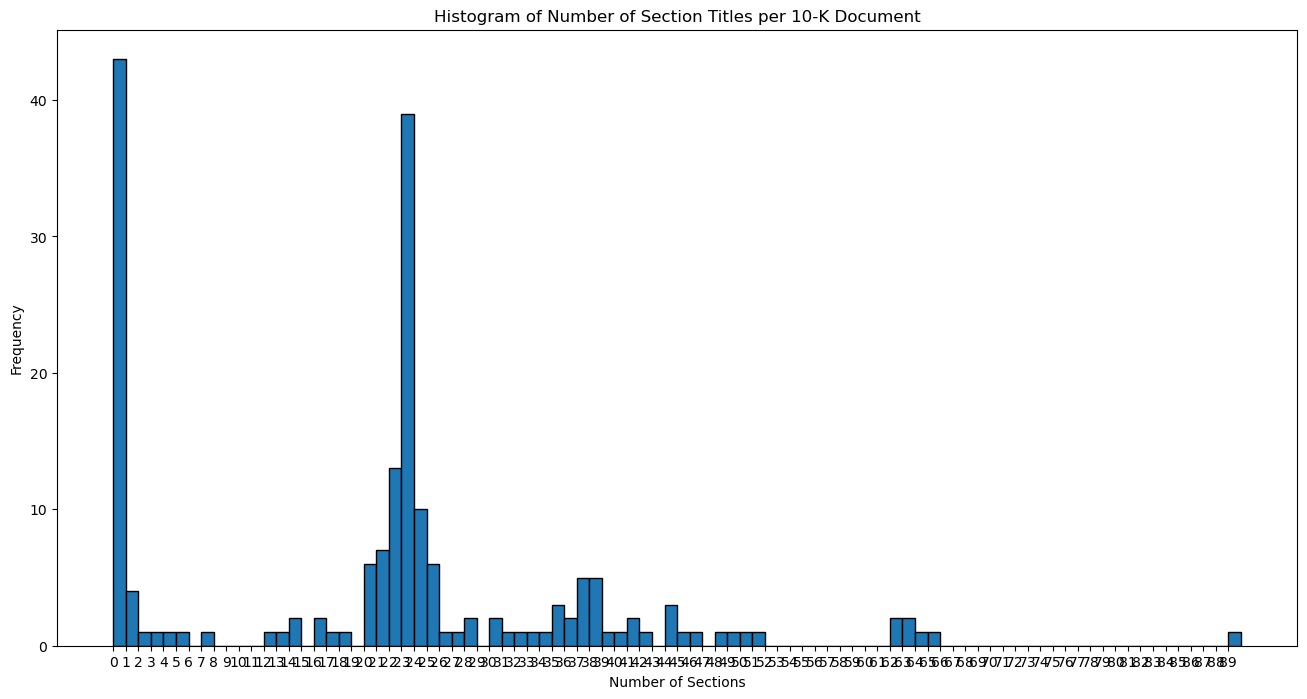

In [47]:
import matplotlib.pyplot as plt

section_counts = [len(document) for document in parsed_10k]

plt.figure(figsize=(16, 8))
plt.hist(section_counts, bins=range(min(section_counts), max(section_counts) + 2), edgecolor='black')
plt.title('Histogram of Number of Section Titles per 10-K Document')
plt.xlabel('Number of Sections')
plt.ylabel('Frequency')
plt.xticks(range(min(section_counts), max(section_counts) + 1))
plt.show()

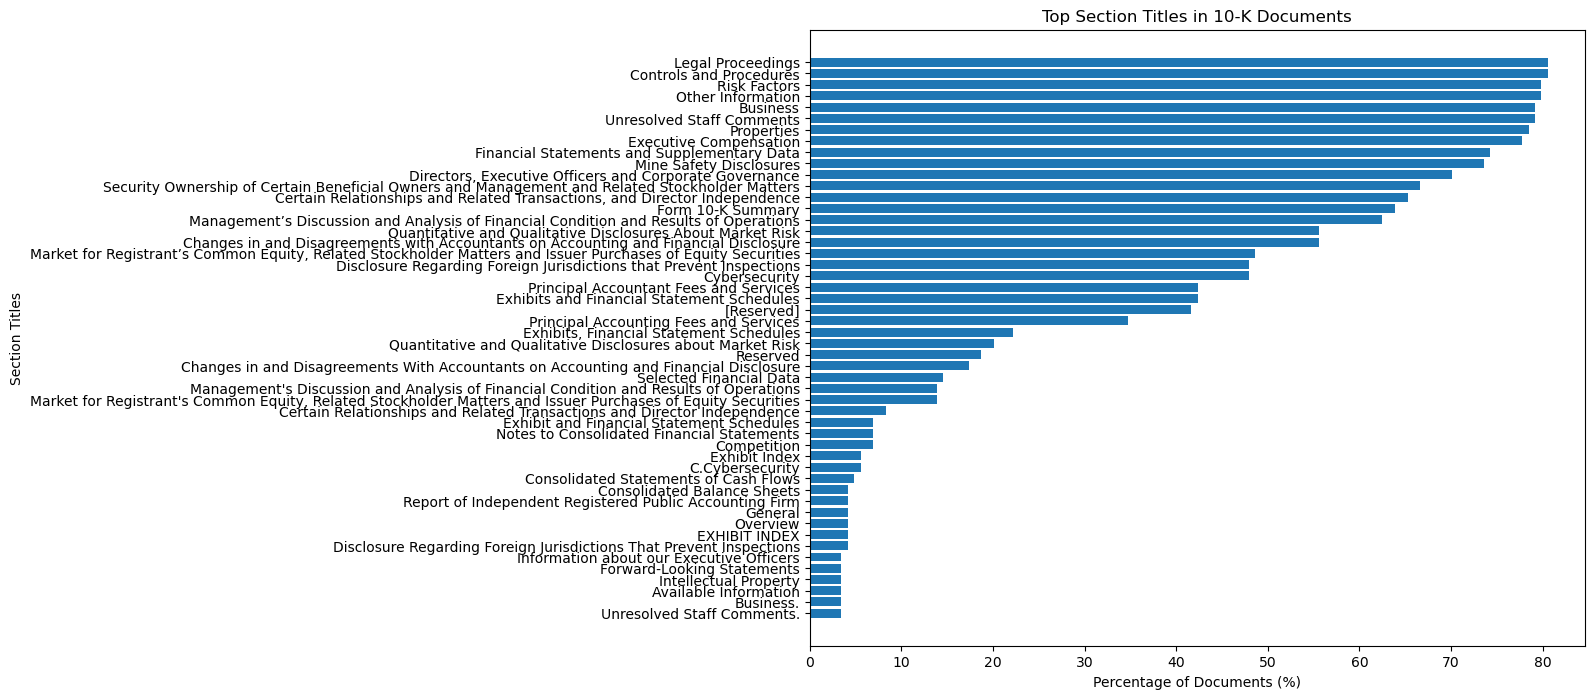

['Legal Proceedings',
 'Controls and Procedures',
 'Risk Factors',
 'Other Information',
 'Business',
 'Unresolved Staff Comments',
 'Properties',
 'Executive Compensation',
 'Financial Statements and Supplementary Data',
 'Mine Safety Disclosures',
 'Directors, Executive Officers and Corporate Governance',
 'Security Ownership of Certain Beneficial Owners and Management and Related Stockholder Matters',
 'Certain Relationships and Related Transactions, and Director Independence',
 'Form 10-K Summary',
 'Management’s Discussion and Analysis of Financial Condition and Results of Operations',
 'Quantitative and Qualitative Disclosures About Market Risk',
 'Changes in and Disagreements with Accountants on Accounting and Financial Disclosure',
 'Market for Registrant’s Common Equity, Related Stockholder Matters and Issuer Purchases of Equity Securities',
 'Disclosure Regarding Foreign Jurisdictions that Prevent Inspections',
 'Cybersecurity',
 'Principal Accountant Fees and Services',
 'Ex

In [59]:
from collections import Counter

all_titles = [title for document in parsed_10k for title in document.keys()]
title_counts = Counter(all_titles)
top_titles = title_counts.most_common(50)
top_titles_list = [title for title, count in top_titles]
total_documents = len([d for d in parsed_10k if d])
top_titles_percentages = [(title, count / total_documents * 100) for title, count in top_titles]

titles, percentages = zip(*top_titles_percentages)
plt.figure(figsize=(10, 8))
plt.barh(titles, percentages)
plt.xlabel('Percentage of Documents (%)')
plt.ylabel('Section Titles')
plt.title('Top Section Titles in 10-K Documents')
plt.gca().invert_yaxis()
plt.show()

top_titles_list

Compiling all data into dataframe

In [ ]:
df_cik = pd.DataFrame({
    'Company Name': train_names,
    'CIK URL': all_cik_results
})
df_10k = pd.DataFrame({
    'CIK URL': valid_cik_results,
    '10K URL': all_10k_results
})
df_inital = pd.merge(df_cik, df_10k, on='CIK URL', how='left').drop_duplicates()
df_sections = pd.DataFrame({
    '10K URL': valid_10k_results,
    'Content': parsed_10k
})
df = pd.merge(df_inital, df_sections, on='10K URL', how='left').drop_duplicates(subset=['Company Name', 'CIK URL', '10K URL'])
df = df.where(pd.notna(df), None)

Statistics of Evaluation

In [41]:
count_all = df.shape[0]
count_cik = df['CIK URL'].notna().sum()
count_10k = df['10K URL'].notna().sum()
count_sections = df['Content'].apply(lambda x: len(x.items()) > 0 if x is not None else False).sum()
count_all, count_cik, count_10k, count_sections
print(f"Test Size: {count_all}")
print(f"CIK Count: {count_cik}, Among All: {count_cik/count_all:.3f}")
print(f"10K Count: {count_10k},  Among All: {count_10k/count_all:.3f}")
print(f"Section>0: {count_sections},  Among 10K: {count_sections/count_10k:.3f}")

Test Size: 3294
CIK Count: 956, Among All: 0.290
10K Count: 187,  Among All: 0.057
Section>0: 144,  Among 10K: 0.770


Exporting sample result data

In [ ]:
df[df['Content'].apply(lambda x: 20 < len(x.items()) and len(x.items()) < 35 if x is not None else False)]

In [37]:
df[['Company Name', 'Content']].to_csv('/Users/SFL/Documents/1 Learn/UBC/Capstone/sample_10k_data.csv', index=False)

Error analysis

In [ ]:
df[df['Content'].apply(lambda x: len(x.items()) == 0 if x is not None else False)]['10K URL'].tolist()

In [ ]:
df[df['Content'].apply(lambda x: len(x.items()) == 0 if x is not None else False)].iloc[0]['10K URL']

### Post-Processing of sections

In [84]:
# List of essential sections
essential_sections = [
    'Business', 'Risk Factors', 'Quantitative and Qualitative Disclosures About Market Risk', 'Properties',
    'Legal Proceedings', 'Controls and Procedures', 'Financial Statements and Supplementary Data', 
    'Executive Compensation', 'Directors, Executive Officers and Corporate Governance', 
    'Security Ownership of Certain Beneficial Owners and Management and Related Stockholder Matters', 
    'Management’s Discussion and Analysis of Financial Condition and Results of Operations', 
    'Market for Registrant’s Common Equity, Related Stockholder Matters and Issuer Purchases of Equity Securities', 
    'Cybersecurity', 'Selected Financial Data', 'Competition', 
    'Certain Relationships and Related Transactions, and Director Independence', 
    'Changes in and Disagreements with Accountants on Accounting and Financial Disclosure', 
    'Disclosure Regarding Foreign Jurisdictions that Prevent Inspections', 
    'Principal Accountant Fees and Services', 'Exhibits and Financial Statement Schedules'
]

Fuzzy similarity matching

In [87]:
from fuzzywuzzy import process, fuzz

def find_best_match(key, choices):
    best_match = process.extractOne(key, choices, scorer=fuzz.ratio)
    if best_match[1] >= 80:  # Only consider it a match if the score is 80 or higher
        return best_match[0]
    return None

# Function to restructure the content with fuzzy matching
def restructure_content(content):
    if content is None:
        return None
    structured_content = {}
    for key, value in content.items():
        match = find_best_match(key, essential_sections)
        if match:
            structured_content[match] = value
    return structured_content

df['Structured'] = df['Content'].apply(restructure_content)
df['Structured'] = df['Structured'].apply(lambda x: None if x == {} else x)

In [ ]:
df[df['Structured'].apply(lambda x: len(x.items()) > 0 if x is not None else False)]

In [ ]:
df[df['Structured'].apply(lambda x: len(x) > 0 and all(v for v in x.values()) if x is not None else False)]

In [186]:
df[df['Structured'].apply(lambda x: len(x.items()) > 0 if x is not None else False)].iloc[2, 4]

{'Business': '',
 'Risk Factors': '',
 'Cybersecurity': '',
 'Properties': '',
 'Legal Proceedings': '',
 'Market for Registrant’s Common Equity, Related Stockholder Matters and Issuer Purchases of Equity Securities': '',
 'Management’s Discussion and Analysis of Financial Condition and Results of Operations': '',
 'Quantitative and Qualitative Disclosures About Market Risk': '',
 'Financial Statements and Supplementary Data': '',
 'Changes in and Disagreements with Accountants on Accounting and Financial Disclosure': '',
 'Controls and Procedures': '',
 'Disclosure Regarding Foreign Jurisdictions that Prevent Inspections': '',
 'Directors, Executive Officers and Corporate Governance': '',
 'Executive Compensation': '',
 'Security Ownership of Certain Beneficial Owners and Management and Related Stockholder Matters': '',
 'Certain Relationships and Related Transactions, and Director Independence': '',
 'Principal Accountant Fees and Services': '',
 'Exhibits and Financial Statement Sch

Visualizing post-processing stats

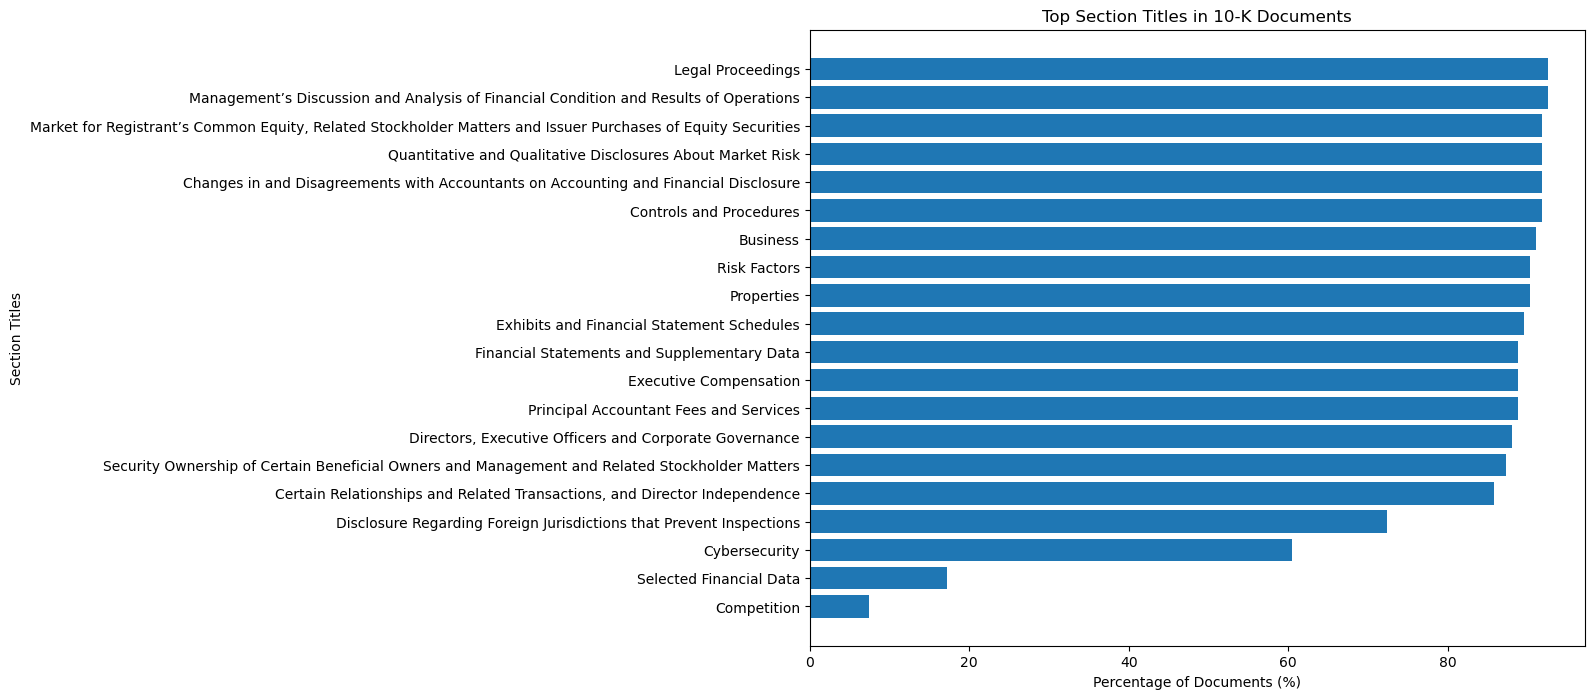

In [89]:
all_titles = [title for document in df['Structured'].dropna() for title in document.keys()]
title_counts = Counter(all_titles)
top_titles = title_counts.most_common(50)
total_documents = len(df['Structured'].dropna())
top_titles_percentages = [(title, count / total_documents * 100) for title, count in top_titles]
titles, percentages = zip(*top_titles_percentages)

plt.figure(figsize=(10, 8))
plt.barh(titles, percentages)
plt.xlabel('Percentage of Documents (%)')
plt.ylabel('Section Titles')
plt.title('Top Section Titles in 10-K Documents')
plt.gca().invert_yaxis()
plt.show()

## Experimenting with LLM

In [ ]:
from meta_ai_api import MetaAI
ai = MetaAI()

In [153]:
link = 'https://www.sec.gov/Archives/edgar/data/778972/000143774914003821/fbmi20131231_10k.htm'

ai.prompt(message=f"{link} Search the text of the 10-K filing for the 'Risk Factors' item and provide its content; if not found, return 'None'.")['message']

'Risk Factors\nThe risks and uncertainties described below are not the only ones we face. Additional risks and uncertainties not presently known to us or that we currently deem immaterial may also impair our business operations. If any of the following risks occur, our business, financial condition, and results of operations could be materially harmed.\nRisks Related to Our Business\nWe may not be able to sustain our revenue growth rate.\nWe may not be able to maintain our profitability.\nWe may not be able to compete effectively in the highly competitive markets in which we operate.\nWe may not be able to continue to develop and launch new and innovative products and services.\nWe may not be able to maintain our brand and reputation.\nWe may not be able to attract and retain skilled employees.\nWe may not be able to manage our growth effectively.\nWe may not be able to maintain our global operations effectively.\nWe may not be able to comply with increasingly complex and changing laws

In [154]:
test_result = {}
for section in tqdm(essential_sections):
    content = ai.prompt(message=f"{link} Search the text of the 10-K filing for the '{section}' item and provide its content; if not found, return 'None'.")['message']
    test_result[section] = content
test_result

100%|██████████| 20/20 [05:14<00:00, 15.73s/it]


{'Business': "The 'Business' item from the 10-K filing is:\nItem 1. Business.\nMeta Platforms, Inc., (“Facebook” or the “Company”) is a technology company that is headquartered in Menlo Park, California. We are a global community of people who use Facebook, Instagram, WhatsApp, or each of their respective family of products. Our products empower people to connect, share, discover, and communicate with each other on mobile devices and personal computers. We have the following reportable segments:\nAdvertising (Facebook and Instagram)\nPayment Processing Fees (Facebook and WhatsApp)\nConsumer Hardware (Oculus)\nOther (Oculus and other products)\nWe had 2.50 billion monthly active users (MAUs) as of December 31, 2013.\nNone of the information contained in this filing constitutes an offer to sell or a solicitation of an offer to buy any securities of the Company.\nLet me know if you need any further assistance!\n",
 'Risk Factors': "Risk Factors\nThe following are some of the key factors t

Testing message generation with Meta.ai API

In [100]:
ai.prompt(message="""
Use the the most prominent aspect of the below a reciever's information to generate a short first line that includes a greeting and affirmation/congratulation/compliment of their experience to be used for an intial linkedin personalized cold outreach message that hooks their attention, reply as if you are sending me that message, so only return the sentence itself and nothing else:

ITEM 1. BUSINESS
Proposed Merger with General Mills, Inc.
On February 22, 2018, Blue Buffalo Pet Products, Inc., General Mills, Inc., a Delaware corporation (“GMI”), and Bravo Merger Corp., a Delaware corporation and wholly-owned subsidiary of GMI (“Merger Sub”), entered into an Agreement and Plan of Merger (the “Merger Agreement”), pursuant to which, on the terms and subject to the conditions set forth in the Merger Agreement, GMI agreed to acquire the Company for $40.00 per common share, in cash.
On the terms and subject to the conditions set forth in the Merger Agreement, Merger Sub will merge with and into the Registrant (the “Merger”), with the Registrant continuing as the surviving company and as a wholly-owned subsidiary of GMI, and our common stock will be delisted from the NASDAQ Stock Market. At the effective time of the Merger, each share of our common stock (other than shares of the Company’s common stock held by GMI, Merger Sub or any other wholly-owned subsidiary of GMI, shares owned by the Company (including shares held in treasury) or any of its wholly-owned subsidiaries, and shares owned by stockholders who have properly exercised and perfected appraisal rights under Delaware law) will be converted into the right to receive $40.00 in cash per share.
The boards of directors of each of GMI and the Registrant have approved the Merger Agreement and holders of more than 50% of the Registrant’s outstanding shares have approved the transaction. While no other approval of the Registrant’s Board of Directors or shareholders is required to complete the transaction, the closing of the Merger is subject to certain regulatory approvals and other customary closing conditions.
There is no assurance that the Merger will occur. See “Risk Factors-Risks Related to the Pending Merger” in “Part I-Item 1A. Risk Factors.”
Overview
We are one of the fastest growing major pet food companies in the United States, selling dog and cat food made with whole meats, fruits and vegetables, and other high-quality, natural ingredients. BLUE is a billion dollar brand and is the #1 brand in the Wholesome Natural market segment. We currently have approximately 7% share of the U.S. pet food market and feed only 3% of the 184 million pets in the United States. With a proven new user acquisition strategy, we are committed to converting more pet parents into True Blue Believers and continuing to increase our share of the attractive $28 billion U.S. pet food market.
We believe we have built an exceptional company with a breakthrough brand and an innovative business model, backed by our mission and our belief in a large unmet consumer demand for pet food with high-quality, natural ingredients.
Our History
Today, Blue Buffalo Pet Products, Inc. (“BBPP”, and together with its subsidiaries, the “Company,” “we,” “us,” “its,” and “our”) conducts its business exclusively through its wholly-owned operating
""")['message']

'Hi, I wanted to reach out and congratulate you on the impressive merger with General Mills, Inc. - quite an achievement!\n'

In [133]:
ai.prompt(message="""
https://www.sec.gov/Archives/edgar/data/1694426/000169442624000028/dk-20231231.htm#i6fa8754773d643bcbfbf1e33d05e1689_265
Read the above 10-K filing link, if there isn't a item called 'MARKET FOR REGISTRANT'S COMMON EQUITY, RELATED STOCKHOLDER MATTERS AND ISSUER PURCHASES OF EQUITY SECURITIES', return 'None" and nothing else; if there is, provide the above link's content of item 'MARKET FOR REGISTRANT'S COMMON EQUITY, RELATED STOCKHOLDER MATTERS AND ISSUER PURCHASES OF EQUITY SECURITIES'.
""")['message']

'MARKET FOR REGISTRANT\'S COMMON EQUITY, RELATED STOCKHOLDER MATTERS AND ISSUER PURCHASES OF EQUITY SECURITIES\nAs of December 31, 2023, the Company\'s common stock is listed on the New York Stock Exchange (NYSE) under the ticker symbol "DK".\nThe following table sets forth the high and low sales prices for the Company\'s common stock as reported on the NYSE for the periods indicated:\nQuarterHighLowFirst Quarter 2023$63.95$45.06Second Quarter 2023$73.94$56.12Third Quarter 2023$81.11$65.23Fourth Quarter 2023$95.00$74.51\nAs of December 31, 2023, there were approximately 342 holders of record of the Company\'s common stock.\nThe Company did not repurchase any shares of its common stock during the year ended December 31, 2023.\nThe Company\'s board of directors has authorized a total of $10.0 billion for share repurchases under its share repurchase program, of which $5.3 billion remained available as of December 31, 2023.\n'

Packaged Function

In [ ]:
def get_10k(company_name):
    cik_url = get_cik_url(company_name)
    html_url = get_10k_url(cik_url)
    html_content = get_10k_file(html_url)
    result = extract_sections(html_content)
    return result